### PREVIOUSLY:
-debuged masks with PIL forming image masks. saw they are bad
### TODO:
-check why masks are formed bad. Is Tensor shape correct?

### Imports

In [1]:
import pandas as pd
from fastai.vision.all import *
#from fastai.utils.mem import *

In [26]:
import pathlib
import os
import PIL

In [3]:
path = pathlib.Path().absolute()
path = os.path.join(path, "Assets", "Data")
path

'/home/carrotpie/code/classB/SegmentationLearner/Assets/Data'

In [4]:
codes = pd.read_csv(os.path.join(path,'labels.csv'))
codes.head()

,LabelName,LabelColor_Red,LabelColor_Green,LabelColor_Blue
0,building_wall,0,124,166
1,building_floor,0,69,120
2,building_ceiling,0,178,166
3,building_door,0,140,126
4,furniture_doubleBed,71,110,0


In [5]:
codes.shape

(26, 4)

In [6]:
fnames = get_image_files(os.path.join(path,"screenshots"))
fnames[0]

Path('/home/carrotpie/code/classB/SegmentationLearner/Assets/Data/screenshots/75.png')

In [7]:
def label_func(fn): return os.path.join(path,"labels",f"{fn.stem}{fn.suffix}")

# Data Loading

In [15]:
room_dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes.LabelName)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(120,160)))

In [16]:
dls = room_dblock.dataloaders(os.path.join(path,"screenshots"), path=path, bs=8)

In [12]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, codes=codes.LabelName,item_tfms=Resize(256)
)

In [40]:
??get_image_files

Signature: get_image_files(path, recurse=True, folders=None)
Source:   
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)
File:      ~/code/classB/classB_env/lib/python3.6/site-packages/fastai/data/transforms.py
Type:      function


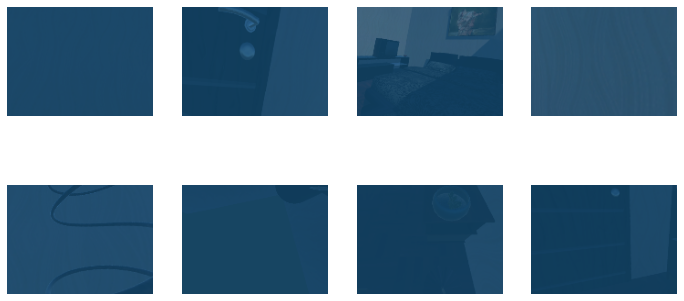

In [25]:
dls.show_batch(vmin=0, vmax=25, cmap='tab20')

In [44]:
#test how mask is shown, from: https://docs.fast.ai/vision.core.html
cam_fn = fnames[0]
mask_fn = label_func(cam_fn)

In [45]:
cam_img = PILImage.create(cam_fn)
test_eq(cam_img.size, (640,480))
tmask = Transform(PILMask.create)
mask = tmask(mask_fn)
test_eq(type(mask), PILMask)
test_eq(mask.size, (640,480))

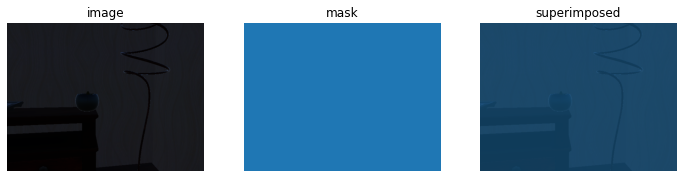

In [46]:
_,axs = plt.subplots(1,3, figsize=(12,3))
cam_img.show(ctx=axs[0], title='image')
mask.show(alpha=1, ctx=axs[1], vmin=1, vmax=30, title='mask')
cam_img.show(ctx=axs[2], title='superimposed')
mask.show(ctx=axs[2], vmin=1, vmax=30);

<AxesSubplot:>

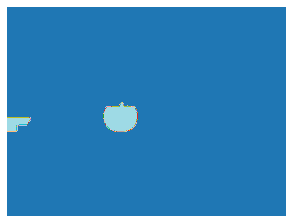

In [39]:
mask = PILMask.create(label_func(fnames[0]))
mask.show(figsize=(5, 5), alpha=1, cmap='tab20')

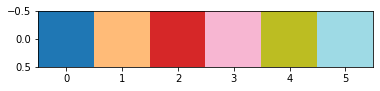

In [21]:
plt.imshow(np.array([[0, 1, 2, 4, 5, 6]]), vmin=0, vmax=6, cmap='tab20')

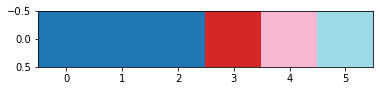

In [24]:
plt.imshow(np.array([[0, 1, 2, 4, 5, 6]]), vmin=3, vmax=6, cmap='tab20')

# Training

In [47]:
learn = unet_learner(dls, resnet34, n_out=len(codes.LabelName)).to_fp16()

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0831763744354248)

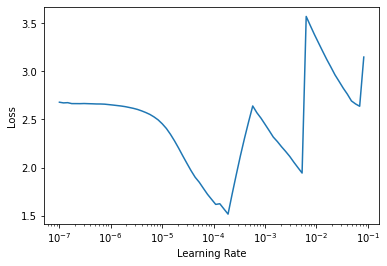

In [48]:
learn.lr_find()

In [49]:
learn.model = learn.model.cpu()

In [50]:
learn.fine_tune(6)

epoch,train_loss,valid_loss,time
0,1.864333,0.324016,00:02


epoch,train_loss,valid_loss,time
0,0.136673,0.067025,00:02
1,0.154613,0.144392,00:02
2,0.112332,0.124758,00:02
3,0.090090,0.095180,00:02
4,0.074260,0.138907,00:02
5,0.062366,0.130963,00:02


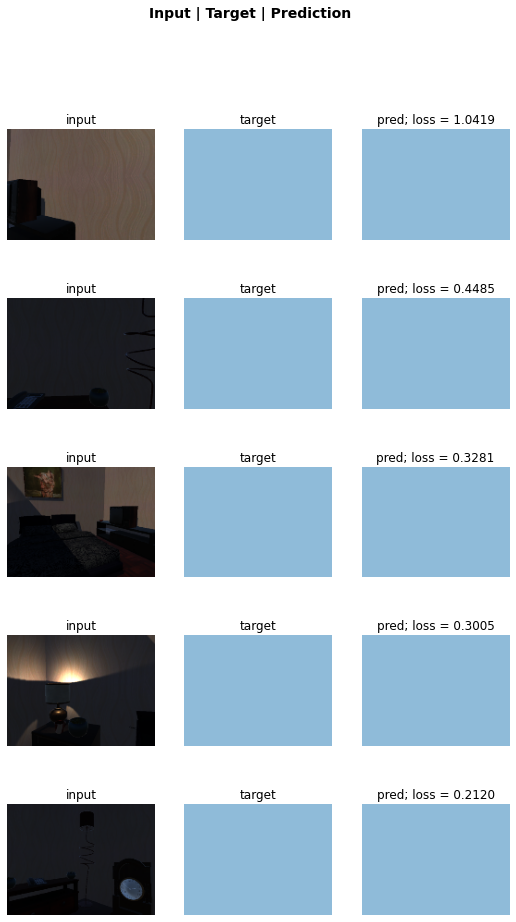

In [51]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=5)

In [41]:
#learn.summary()